# Machine Learning and Data Science (MALDSAC) 2024

In this demo, we will get hands-on experience on GANs

## Imports

In [ ]:
# Import necessary libraries
import time                       # For time-related operations
import numpy as np                # For numerical operations
import torch                      # PyTorch library for deep learning
import torch.nn.functional as F   # PyTorch functional interface
from torchvision import datasets # Datasets provided by torchvision
from torchvision import transforms  # Transformations for image preprocessing
import torch.nn as nn             # Neural network modules provided by PyTorch
from torch.utils.data import DataLoader  # DataLoader for handling datasets in PyTorch
import matplotlib.cm as cm

# Import matplotlib for plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Check if CUDA (GPU) is available and set deterministic behavior for CuDNN
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Global Settings

In [ ]:
##########################
### SETTINGS
##########################

# Device: Set the device to CUDA (GPU) if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123  # Random seed for reproducibility
generator_learning_rate = 0.001  # Learning rate for the generator
discriminator_learning_rate = 0.001  # Learning rate for the discriminator
NUM_EPOCHS = 100  # Number of training epochs
BATCH_SIZE = 128  # Batch size for training
LATENT_DIM = 75  # Dimensionality of the latent space
IMG_SHAPE = (1, 28, 28)  # Shape of the input images (1 channel, 28x28 pixels)
IMG_SIZE = 1  # Initialize IMG_SIZE variable
for x in IMG_SHAPE:
    IMG_SIZE *= x  # Calculate the total number of features in the input image


print(IMG_SIZE)

784


## Dataset
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

<center>
<a href="http://yann.lecun.com/exdb/mnist/">
<img src="https://drive.google.com/uc?export=view&id=13JlBCTfoRd0hzkuf3txMvyU2dI9jga7_" width="100%"/>
</a>
<center/>
<center> Figure. MNIST Handwritten digits dataset </center>

In [ ]:
##########################
### MNIST DATASET
##########################

# Define training dataset: MNIST, consisting of handwritten digits
train_dataset = datasets.MNIST(root='data',        # Root directory to save the dataset
                               train=True,        # Set to True to load the training set
                               transform=transforms.ToTensor(),  # Convert images to PyTorch tensors
                               download=True)     # Download the dataset if not already downloaded

# Create DataLoader for training dataset, to load data in batches during training
train_loader = DataLoader(dataset=train_dataset,   # Training dataset to load
                          batch_size=BATCH_SIZE,  # Batch size for training
                          shuffle=True)          # Shuffle the data at each epoch

100%|██████████| 9912422/9912422 [00:00<00:00, 163518452.76it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 109427004.36it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 105291953.73it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23606603.18it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



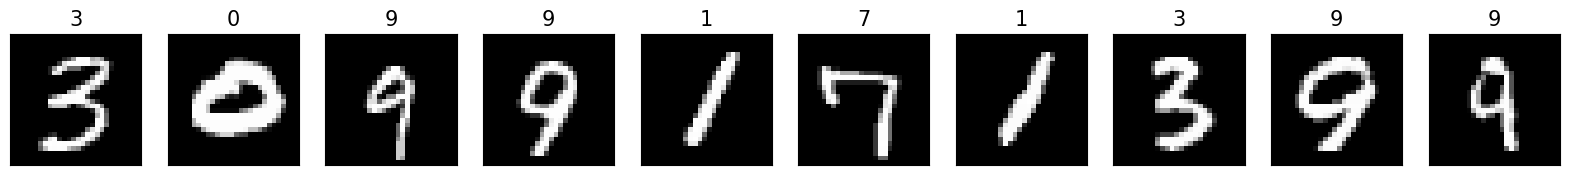

In [ ]:
nsamples = 10
classes_names = ['0', '1', '2', '3', '4', '5','6', '7', '8', '9']
imgs, labels = next(iter(train_loader))

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
# Define test dataset: MNIST test set
test_dataset = datasets.MNIST(root='data',         # Root directory to save the dataset
                              train=False,         # Set to False to load the test set
                              transform=transforms.ToTensor())  # Convert images to PyTorch tensors

# Create DataLoader for test dataset, to load data in batches during testing/evaluation
test_loader = DataLoader(dataset=test_dataset,     # Test dataset to load
                         batch_size=BATCH_SIZE,   # Batch size for testing
                         shuffle=False)           # Do not shuffle the data during testing

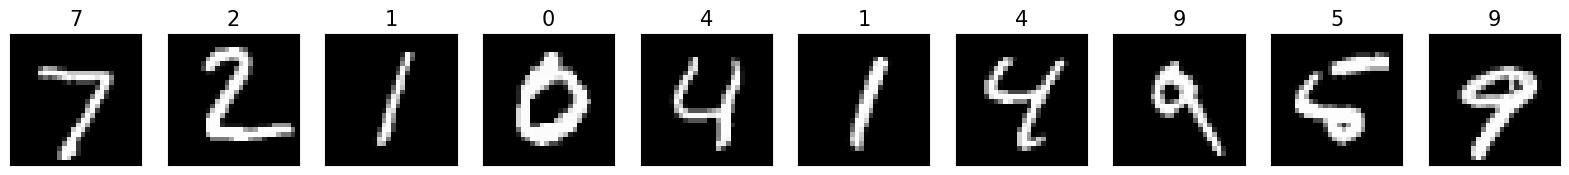

In [ ]:
nsamples=10
classes_names = ['0', '1', '2', '3', '4', '5','6', '7', '8', '9']
imgs, labels = next(iter(test_loader))

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [ ]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))

The train set contains 60000 images, in 469 batches
The test set contains 10000 images, in 79 batches


## Model

In [ ]:
##########################
### MODEL
##########################


# Define a GAN class inheriting from torch.nn.Module
class GAN(torch.nn.Module):

    # Constructor method to initialize the GAN
    def __init__(self):
        super(GAN, self).__init__()

        # Define the generator neural network architecture
        self.generator = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),    # Linear layer with input size of LATENT_DIM and output size of 128
            nn.LeakyReLU(inplace=True),    # Leaky ReLU activation function
            nn.Dropout(p=0.5),             # Dropout layer with dropout probability of 0.5
            nn.Linear(128, IMG_SIZE),      # Linear layer with input size of 128 and output size of IMG_SIZE
            nn.Tanh()                      # Tanh activation function to normalize output to range [-1, 1]
        )

        # Define the discriminator neural network architecture
        self.discriminator = nn.Sequential(
            nn.Linear(IMG_SIZE, 128),      # Linear layer with input size of IMG_SIZE and output size of 128
            nn.LeakyReLU(inplace=True),    # Leaky ReLU activation function
            nn.Dropout(p=0.5),             # Dropout layer with dropout probability of 0.5
            nn.Linear(128, 1),             # Linear layer with input size of 128 and output size of 1
            nn.Sigmoid()                   # Sigmoid activation function for binary classification
        )

    # Method for forward pass of the generator
    def generator_forward(self, z):
        img = self.generator(z)  # Pass input noise vector z through the generator
        return img               # Return the generated image

    # Method for forward pass of the discriminator
    def discriminator_forward(self, img):
        pred = self.discriminator(img)  # Pass input image through the discriminator
        return pred.view(-1)            # Flatten and return the discriminator's prediction

Initliase model

In [ ]:
torch.manual_seed(random_seed)

model = GAN()
model = model.to(device)

## Optimiser
-------------------

In order to update the model parameters using the computed gradients (`backward()`), we need  to define an optimizer which as its names says, it optimizes the parameters of a neural network is
performed by some kind of gradient descent. In PyTorch there are different optimizers
provided in the [torch.optim
package](https://pytorch.org/docs/stable/optim.html). We will focus on the [SGD
optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.sgd) and on the
[Adam
optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam), which are two of the most common and stable optimizers. For that purposes, the optimizer needs a reference to the parameters that it needs
to modify.

```
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
```

```
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
```

In [ ]:
# Define optimizer for the Generator and setting learning rate
optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate)

In [ ]:
# Define optimizer for the Discriminator and setting learning rate
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

## Train

In [ ]:
# Start tracking time for training duration
start_time = time.time()

# Lists to store discriminator and generator costs for logging
discr_costs = []
gener_costs = []

# Train over epochs
for epoch in range(NUM_EPOCHS):

    # Set the model in training mode
    model = model.train()

    # Iterate over batches in the training loader
    for batch_idx, (features, targets) in enumerate(train_loader):

        # Preprocess features (normalize to range [-1, 1])
        features = (features - 0.5)*2.

        # Vectorise image to vector
        features = features.view(-1, IMG_SIZE).to(device)
        targets = targets.to(device)

        # Create tensors for real and fake labels
        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)


        ### FORWARD AND BACK PROP


        # --------------------------
        # Train Generator G()
        # --------------------------

        # Train Generator
        # Generate synthetic samples
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(z)

        # Calculate generator loss based on discriminator's prediction
        discr_pred = model.discriminator_forward(generated_features)
        gener_loss = F.binary_cross_entropy(discr_pred, valid)

        # Backpropagate and update generator's parameters
        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()

        # --------------------------
        # Train Discriminator D()
        # --------------------------

        # Calculate discriminator loss for real samples
        discr_pred_real = model.discriminator_forward(features.view(-1, IMG_SIZE))
        real_loss = F.binary_cross_entropy(discr_pred_real, valid)

        # Calculate discriminator loss for synthetic images
        discr_pred_fake = model.discriminator_forward(generated_features.detach())
        fake_loss = F.binary_cross_entropy(discr_pred_fake, fake)

        # Overall discriminator loss
        discr_loss = 0.5*(real_loss + fake_loss)

        # Backpropagate and update discriminator's parameters
        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()

        # Log discriminator and generator losses
        discr_costs.append(discr_loss)
        gener_costs.append(gener_loss)


        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), gener_loss, discr_loss))

    # Print elapsed time for each epoch
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

# Print total training time
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Batch 000/469 | Gen/Dis Loss: 0.6516/0.7081
Epoch: 001/100 | Batch 100/469 | Gen/Dis Loss: 5.0422/0.0353
Epoch: 001/100 | Batch 200/469 | Gen/Dis Loss: 1.7976/0.1096
Epoch: 001/100 | Batch 300/469 | Gen/Dis Loss: 1.4743/0.1647
Epoch: 001/100 | Batch 400/469 | Gen/Dis Loss: 2.2171/0.0878
Time elapsed: 0.27 min
Epoch: 002/100 | Batch 000/469 | Gen/Dis Loss: 1.6841/0.2443
Epoch: 002/100 | Batch 100/469 | Gen/Dis Loss: 1.7972/0.2089
Epoch: 002/100 | Batch 200/469 | Gen/Dis Loss: 1.2132/0.3058
Epoch: 002/100 | Batch 300/469 | Gen/Dis Loss: 1.2526/0.3411
Epoch: 002/100 | Batch 400/469 | Gen/Dis Loss: 0.9571/0.4133
Time elapsed: 0.40 min
Epoch: 003/100 | Batch 000/469 | Gen/Dis Loss: 1.0954/0.3931
Epoch: 003/100 | Batch 100/469 | Gen/Dis Loss: 0.9545/0.4301
Epoch: 003/100 | Batch 200/469 | Gen/Dis Loss: 0.7646/0.5385
Epoch: 003/100 | Batch 300/469 | Gen/Dis Loss: 1.0999/0.4240
Epoch: 003/100 | Batch 400/469 | Gen/Dis Loss: 1.2105/0.3573
Time elapsed: 0.54 min
Epoch: 004/100 |

## Evaluation

In [ ]:
# Move the lists gener_costs and discr_costs to CPU
gener_costs_cpu = [cost.cpu().item() for cost in gener_costs]
discr_costs_cpu = [cost.cpu().item() for cost in discr_costs]

<ipython-input-15-cc746abdb815>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(newlabel[::10]) # Set the x-tick labels for the second x-axis


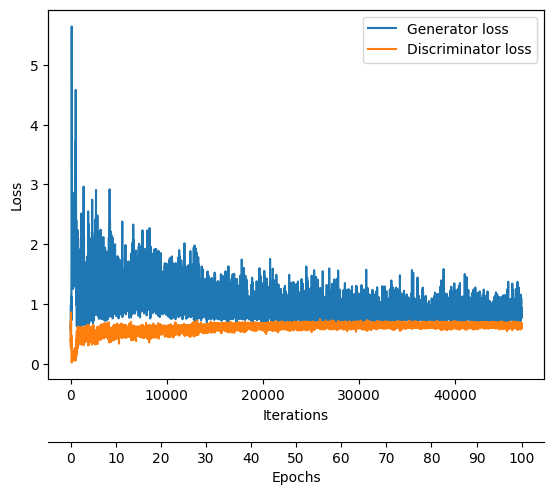

In [ ]:
ax1 = plt.subplot(1, 1, 1) # Create a subplot with 1 row, 1 column, and select the first subplot
ax1.plot(range(len(gener_costs_cpu)), gener_costs_cpu, label='Generator loss') # Plot the generator loss over iterations
ax1.plot(range(len(discr_costs_cpu)), discr_costs_cpu, label='Discriminator loss') # Plot the discriminator loss over iterations
ax1.set_xlabel('Iterations') # Set the label for the x-axis
ax1.set_ylabel('Loss')  # Set the label for the y-axis
ax1.legend() # Add a legend to the plot

###################
# Set second x-axis
ax2 = ax1.twiny() # Create a second x-axis sharing the same y-axis with ax1
newlabel = list(range(NUM_EPOCHS+1)) # Create new labels for the epochs
iter_per_epoch = len(train_loader) # Calculate the number of iterations per epoch
newpos = [e*iter_per_epoch for e in newlabel] # Calculate the positions for the new x-ticks
ax2.set_xticklabels(newlabel[::10]) # Set the x-tick labels for the second x-axis
ax2.set_xticks(newpos[::10]) # Set the x-tick positions for the second x-axis
ax2.xaxis.set_ticks_position('bottom') # Set the ticks position to bottom for the second x-axis
ax2.xaxis.set_label_position('bottom') # Set the label position to bottom for the second x-axis
ax2.spines['bottom'].set_position(('outward', 45)) # Set the position of the bottom spine for the second x-axis
ax2.set_xlabel('Epochs') # Set the label for the x-axis of the second x-axis
ax2.set_xlim(ax1.get_xlim()) # Set the limits for the second x-axis to match the first x-axis
###################

# Display the plot
plt.show()


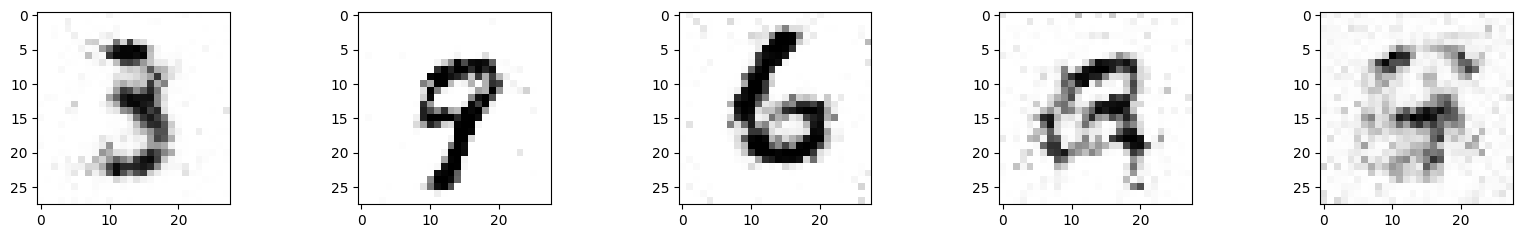

In [ ]:
##########################
### VISUALIZATION
##########################

# Set the model to evaluation mode
model.eval()

# Generate new images by feeding random noise through the generator
z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)

# Reshape the generated features into image format
imgs = generated_features.view(-1, 28, 28)

# Create a subplot with 1 row and 5 columns, specifying the figure size
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))

# Iterate over the generated images and corresponding axes for plotting
for i, ax in enumerate(axes):
    # Display each generated image on its corresponding axis
    # Transfer the image data to CPU and detach it from the computational graph
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')
